In [1]:
# importando as libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import os
import keras
import time
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


2022-11-30 13:32:32.335274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 13:32:32.449846: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-30 13:32:32.865376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-30 13:32:32.865425: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

In [2]:
#
class TFBasicAutoencoder(Model):
  def __init__(self, latent_dim,input_shape):
    super(TFBasicAutoencoder, self).__init__()
    self.latent_dim = latent_dim
    input_size=int(input_shape)#int(input_shape[0]*input_shape[1]*input_shape[2])
    print(input_size)
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(input_size, activation='sigmoid'),      
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

from keras import regularizers


class TFSparsityConstraintAutoencoder(Model):
  
  def __init__(self, latent_dim,input_shape):
    super(TFSparsityConstraintAutoencoder, self).__init__()
    self.latent_dim = latent_dim  
    input_size=int(input_shape)
    self.encoder = tf.keras.Sequential([ 
      layers.Dense(latent_dim, activation='relu',activity_regularizer=regularizers.l1(10e-5)),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(input_size, activation='sigmoid'),      
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


class DeepAutoencoder(Model):
  
  def __init__(self, latent_dim,input_shape):
    super(DeepAutoencoder, self).__init__()
    self.latent_dim = latent_dim  
    input_size=int(input_shape)
    self.encoder = tf.keras.Sequential([ 
    layers.Dense(512, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(input_shape, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(input_size, activation='sigmoid'),      
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


class ConvolutionalAutoencoder(Model):
  
  def __init__(self, latent_dim,input_shape):
    super(ConvolutionalAutoencoder, self).__init__()
    self.latent_dim = latent_dim     
    print(input_shape)
    cam_shape=(int(input_shape[0]/2), int(input_shape[1]/2), 32)
    self.encoder = tf.keras.Sequential(
       [   # tf.keras.layers.Reshape(target_shape=input_shape),
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=(input_shape[0]/2)*(input_shape[1]/2)*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=cam_shape),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
          #  tf.keras.layers.Conv2DTranspose(
           #     filters=32, kernel_size=3, strides=2, padding='same',
            #    activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )


  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

class ConvolutionalAutoencoder1(Model):
  
  def __init__(self, latent_dim,input_shape):
    super(ConvolutionalAutoencoder1, self).__init__()
    self.latent_dim = latent_dim     
    print(input_shape)
    self.encoder = tf.keras.Sequential(
       [   # tf.keras.layers.Reshape(target_shape=input_shape),
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=10*14*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(10, 14, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
          #  tf.keras.layers.Conv2DTranspose(
           #     filters=32, kernel_size=3, strides=2, padding='same',
            #    activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )


  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [14]:
def data_reshape(x_train,x_test):
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    return x_train,x_test

def dataset_reshape(x_train,x_test,dataset):
    if(dataset=='Kuhar'):
        x_train = x_train.reshape(( len(x_train),100,-1,1))
        x_test = x_test.reshape((len(x_test),100,-1,1))
        return x_train,x_test
    if(dataset=='Motionsense'):
        x_train = x_train.reshape(( len(x_train),20,-1,1))
        x_test = x_test.reshape((len(x_test),20,-1,1))
        return x_train,x_test
    if(dataset=='Custom'):
        x_train = x_train.reshape(( len(x_train),100,-1,1))
        x_test = x_test.reshape((len(x_test),100,-1,1))
        return x_train,x_test


In [15]:
  
def plot_scatter(data,labels,dataset,data_encoded,titles):  
    import umap
    
    rows=2    
    col=int(len(data_encoded)/2 +1)
    plt.figure(figsize=(25, col*5))
    plt.suptitle('Dataset->'+ dataset,fontsize=20)
    dim_reducer = umap.UMAP(n_components=2)    
    data=data.reshape((len(data), np.prod(data.shape[1:])))
    start_time = time.time()
    latent_space_reduced = dim_reducer.fit_transform(data) 
    elapsed_time = time.time() - start_time
    ax = plt.subplot(col, rows, 1)
    plt.scatter(latent_space_reduced[:, 0], latent_space_reduced[:, 1], c=labels, cmap='tab10')
    plt.title("umap latent_dim= 2"+ ' time='+"{:.4f} s".format(elapsed_time))
    plt.colorbar()
    
    t=1
    row=1
    print(col)
    for i, decoded_ in enumerate(data_encoded):
        axc=i+2
        
        
        if(decoded_.shape[1]>2):
            dim_reducer = umap.UMAP(n_components=2)
            decoded_ = dim_reducer.fit_transform(decoded_)   
        ax = plt.subplot(col, rows, axc)
        plt.scatter(decoded_[:, 0], decoded_[:, 1], c=labels, cmap='tab10')
        plt.title(titles[i])
        plt.colorbar()
        
  
    

def plot_loss(loss,titles,dataset):
    plt.figure(figsize=(10, 5))
    plt.suptitle('Loss Dataset->'+ dataset,fontsize=20)
    for l,title in zip(loss,titles):
        plt.plot(l, label=title.split('time')[0])

    plt.legend(loc='upper right')



In [5]:

import numpy as np

import numpy as np
import pandas as pd
import scipy.io as sio

import torch
from torch.utils.data import Dataset


def load_har(path='data/HAR/', start_idx=0, data_num=10000):
    x_train = pd.read_csv(path + 'train/X_train.txt', sep=r'\s+', header=None).iloc[:, :-1]
    y_train = pd.read_csv(path + 'train/y_train.txt', header=None)
    x_test = pd.read_csv(path + 'test/X_test.txt', sep=r'\s+', header=None).iloc[:, :-1]
    y_test = pd.read_csv(path + 'test/y_test.txt', header=None)

    x_train = np.array(x_train).astype(np.float32)
    x_test = np.array( x_test).astype(np.float32)
    #y = np.concatenate((y_train, y_test)).astype(np.int32)
    y_train = y_train - 1
    #y_train = y_train.reshape((y_train.size,))
    #print(('HAR samples', x.shape))

    return x_train[start_idx:start_idx+data_num].astype(np.float32), y_train[start_idx:start_idx+data_num].astype(np.float32),x_test[start_idx:start_idx+data_num].astype(np.float32), y_test[start_idx:start_idx+data_num].astype(np.float32)
    
    
def load_custom(path='./data/ELD/', start_idx=0, data_num=1000):
    x_train = pd.read_csv(path + 'train/X_train.txt', sep=r'\s+', header=None)
    y_train = pd.read_csv(path + 'train/y_train.txt', header=None)
    x_test = pd.read_csv(path + 'test/X_test.txt', sep=r'\s+', header=None)
    y_test = pd.read_csv(path + 'test/y_test.txt', header=None)

    #x = np.concatenate((x_train, x_test)).astype(np.float32)
    #y = np.concatenate((y_train, y_test)).astype(np.int32)
    
    #y = y - 1
    #y = y.reshape((y.size,))
    #print(('ELD samples', x.shape))
    x_train = np.array(x_train).astype(np.float32)
    x_test = np.array( x_test).astype(np.float32)
    #y = np.concatenate((y_train, y_test)).astype(np.int32)
    y_train = y_train - 1

    return x_train[start_idx:start_idx+data_num].astype(np.float32), y_train[start_idx:start_idx+data_num].astype(np.float32),x_test[start_idx:start_idx+data_num].astype(np.float32), y_test[start_idx:start_idx+data_num].astype(np.float32)
    
    
    
    
def load_kuhar(path='./data/ku-HAR/', start_idx=0, data_num=10000):
    x_train = pd.read_csv(path + 'train/X_train.txt', sep=',', header=None).astype(float)
    y_train = pd.read_csv(path + 'train/y_train.txt', header=None).astype(float)
    x_test = pd.read_csv(path + 'test/X_test.txt', sep=',', header=None).astype(float)
    y_test = pd.read_csv(path + 'test/y_test.txt', header=None).astype(float)

    x_train = np.array(x_train).astype(np.float32)
    x_test = np.array(x_test).astype(np.float32)
    y_test = np.array(( y_test)).astype(np.int32)
    
    y_test = y_test - 1
    y_test = y_test.reshape((y_test.size,))
    print(('ku-HAR samples', x_train.shape))

    return x_train.astype(np.float32), y_train.astype(np.float32),x_test.astype(np.float32), y_test.astype(np.float32)
    
#def load_extrasensory(path='./data/ku-HAR/', start_idx=0, data_num=10000):
#    #10.10.1.71:/home/ale/Documents/hiaac/main/meta-6/dataset/folds/exp_


"""
class Dataset(Dataset):

    def __init__(self, start_idx, data_num, datasets='HAR'):
       
        if datasets == 'HAR':
            print("HAR")
            self.x, self.y = load_har(start_idx=start_idx, data_num=data_num)
        if datasets == 'Extrasensory':
            self.x, self.y = load_pendigits(start_idx=start_idx, data_num=data_num)
        if datasets == 'ku-HAR':
            self.x, self.y = load_ku_har(start_idx=start_idx, data_num=data_num)
        if datasets == 'ELD':
            self.x, self.y = load_eld(start_idx=start_idx, data_num=data_num)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(np.array(self.x[idx])), torch.from_numpy(np.array(self.y[idx])), torch.from_numpy(np.array(idx))
"""


'\nclass Dataset(Dataset):\n\n    def __init__(self, start_idx, data_num, datasets=\'HAR\'):\n       \n        if datasets == \'HAR\':\n            print("HAR")\n            self.x, self.y = load_har(start_idx=start_idx, data_num=data_num)\n        if datasets == \'Extrasensory\':\n            self.x, self.y = load_pendigits(start_idx=start_idx, data_num=data_num)\n        if datasets == \'ku-HAR\':\n            self.x, self.y = load_ku_har(start_idx=start_idx, data_num=data_num)\n        if datasets == \'ELD\':\n            self.x, self.y = load_eld(start_idx=start_idx, data_num=data_num)\n\n    def __len__(self):\n        return self.x.shape[0]\n\n    def __getitem__(self, idx):\n        return torch.from_numpy(np.array(self.x[idx])), torch.from_numpy(np.array(self.y[idx])), torch.from_numpy(np.array(idx))\n'

In [59]:
def load_dataset_har(dataset):
    x_train, y_train,x_test,y_test = load_har(start_idx=0, data_num=80000)
    input_shape=x_train.shape[1]      
    return x_train, y_train,x_test,y_test,input_shape

def load_dataset_custom(dataset):
    x_train, y_train,x_test,y_test = load_custom(start_idx=0, data_num=80000)  
    input_shape=x_train.shape[1] 
         
    return x_train, y_train,x_test,y_test,input_shape

def load_dataset_kuhar(dataset):
    x_train, y_train,x_test,y_test = load_kuhar(start_idx=0, data_num=80000)
    input_shape=x_train.shape[1]
    
   
        
    return x_train, y_train,x_test,y_test,input_shape



def load_dataset(dataset):
    if(dataset=='Motionsense'):
        return load_dataset_har(dataset)
    if(dataset=='Custom'):
        return load_dataset_custom(dataset)
    if(dataset=='Kuhar'):
        return load_dataset_kuhar(dataset)
        

In [11]:
def train_datasets(reducers,datasets):

    for dataset in datasets:
        data_encoded = []
        data_decoded = []
        loss= []
        titles= []
        

        for reducer, args in reducers:
            x_train, y_train,x_test,y_test,input_shape=load_dataset(dataset)
            if(reducer==ConvolutionalAutoencoder):        
                x_train,x_test=dataset_reshape(x_train,x_test,dataset)
                input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])
            print(dataset, x_train.shape, y_train.shape,x_test.shape,y_test.shape,input_shape)
            #Train the model using x_train as both the input and the target.
            autoencoder = reducer(latent_dim=args["latent_dim"],input_shape=input_shape)
            autoencoder.compile(optimizer='adam', loss = tf.keras.losses.MeanSquaredLogarithmicError())
            #autoencoder.encoder.summary()
            #autoencoder.decoder.summary()
            hist=autoencoder.fit(x_train, x_train,
                        epochs=args['epochs'],
                        shuffle=True,
                        validation_data=(x_test, x_test))
            start_time = time.time()
            encoded_imgs = autoencoder.encoder(x_test).numpy()
            elapsed_time = time.time() - start_time
            decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
           # print("encoded_imgs->",encoded_imgs.shape)
           # print("decoded_imgs->",decoded_imgs.shape)
            data_encoded.append(encoded_imgs)
            data_decoded.append(decoded_imgs)
            loss.append(hist.history['loss'])
            titles.append(str(reducer).split('__.')[1] +" latent_dim= "+
                          str(args["latent_dim"]) + ' time='+"{:.4f} s".format(elapsed_time))

        plot_scatter(x_test,y_test,dataset,data_encoded,titles)
        plot_loss(loss,titles,dataset)


Motionsense (7352, 560) (7352, 1) (2947, 560) (2947, 1) 560
560
Epoch 1/50
230/230 [==============================] - 1s 2ms/step - loss: 0.0346 - val_loss: 0.0078
Epoch 2/50
230/230 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0057
Epoch 3/50
230/230 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 4/50
230/230 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 5/50
230/230 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 6/50
230/230 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 7/50
230/230 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 8/50
230/230 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 9/50
230/230 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 10/50
230/230 [===============

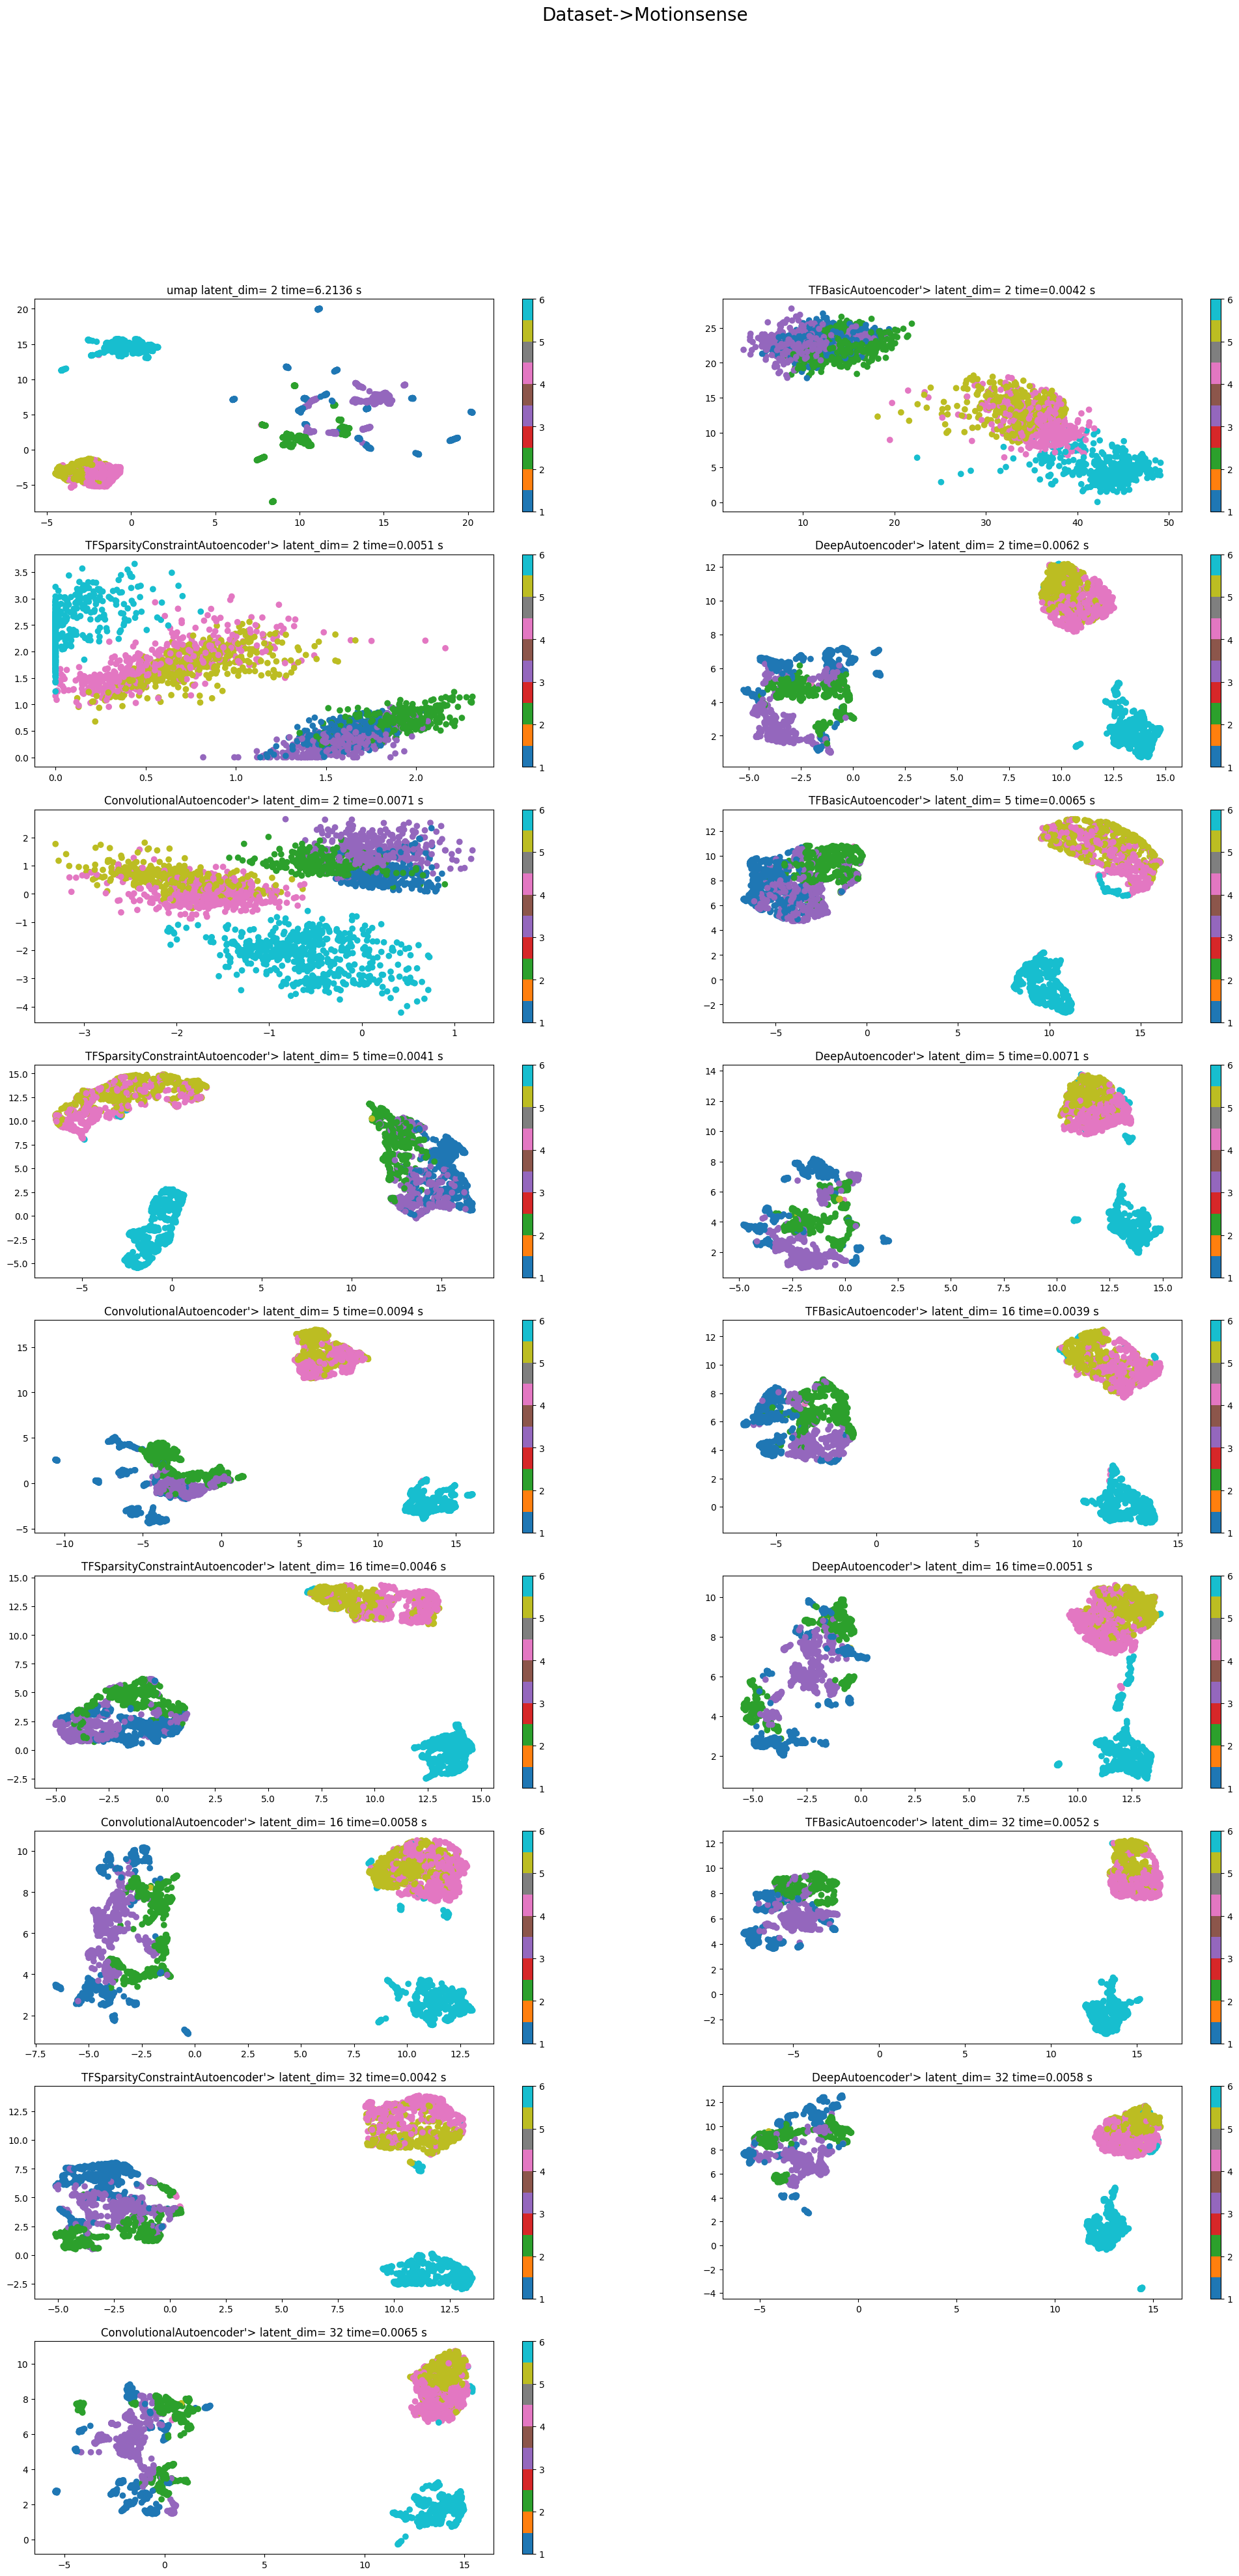

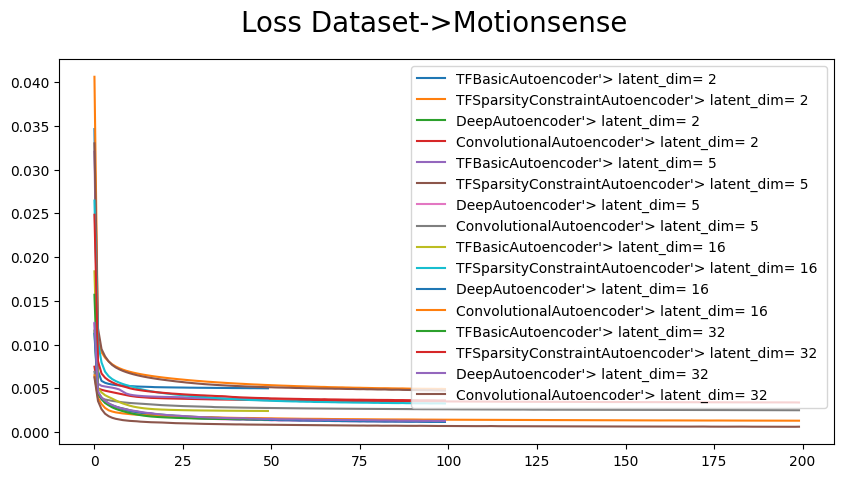

In [12]:
### dataset Motionsense


reducers = [
    (TFBasicAutoencoder, { "latent_dim": 2,'epochs': 50}),
   (TFSparsityConstraintAutoencoder, { "latent_dim": 2,'epochs': 100}),
    (DeepAutoencoder, { "latent_dim": 2,'epochs': 100}),
    (ConvolutionalAutoencoder, { "latent_dim": 2,'epochs': 200}),    
(TFBasicAutoencoder, { "latent_dim": 5,'epochs': 50}),
   (TFSparsityConstraintAutoencoder, { "latent_dim": 5,'epochs': 100}),
   (DeepAutoencoder, { "latent_dim": 5,'epochs': 100}),
   (ConvolutionalAutoencoder, { "latent_dim": 5,'epochs': 200}), 
    
     (TFBasicAutoencoder, { "latent_dim": 16,'epochs': 50}),
   (TFSparsityConstraintAutoencoder, { "latent_dim": 16,'epochs': 100}),
   (DeepAutoencoder, { "latent_dim": 16,'epochs': 100}),
   (ConvolutionalAutoencoder, { "latent_dim": 16,'epochs': 200}), 
    
         (TFBasicAutoencoder, { "latent_dim": 32,'epochs': 50}),
   (TFSparsityConstraintAutoencoder, { "latent_dim": 32,'epochs': 100}),
   (DeepAutoencoder, { "latent_dim": 32,'epochs': 100}),
   (ConvolutionalAutoencoder, { "latent_dim": 32,'epochs': 200}), 
]

datasets= ['Motionsense']

,#'custom','har'kuhar
train_datasets(reducers,datasets)


('ku-HAR samples', (3132, 1800))
Kuhar (3132, 1800) (3132, 1) (306, 1800) (306,) 1800
1800
Epoch 1/50
98/98 [==============================] - 0s 2ms/step - loss: 3.0882 - val_loss: 2.1464
Epoch 2/50
98/98 [==============================] - 0s 2ms/step - loss: 2.8349 - val_loss: 2.1435
Epoch 3/50
98/98 [==============================] - 0s 2ms/step - loss: 2.8321 - val_loss: 2.1409
Epoch 4/50
98/98 [==============================] - 0s 2ms/step - loss: 2.8301 - val_loss: 2.1395
Epoch 5/50
98/98 [==============================] - 0s 2ms/step - loss: 2.8287 - val_loss: 2.1379
Epoch 6/50
98/98 [==============================] - 0s 2ms/step - loss: 2.8271 - val_loss: 2.1363
Epoch 7/50
98/98 [==============================] - 0s 2ms/step - loss: 2.8256 - val_loss: 2.1357
Epoch 8/50
98/98 [==============================] - 0s 2ms/step - loss: 2.8243 - val_loss: 2.1342
Epoch 9/50
98/98 [==============================] - 0s 2ms/step - loss: 2.8230 - val_loss: 2.1327
Epoch 10/50
98/98 [========

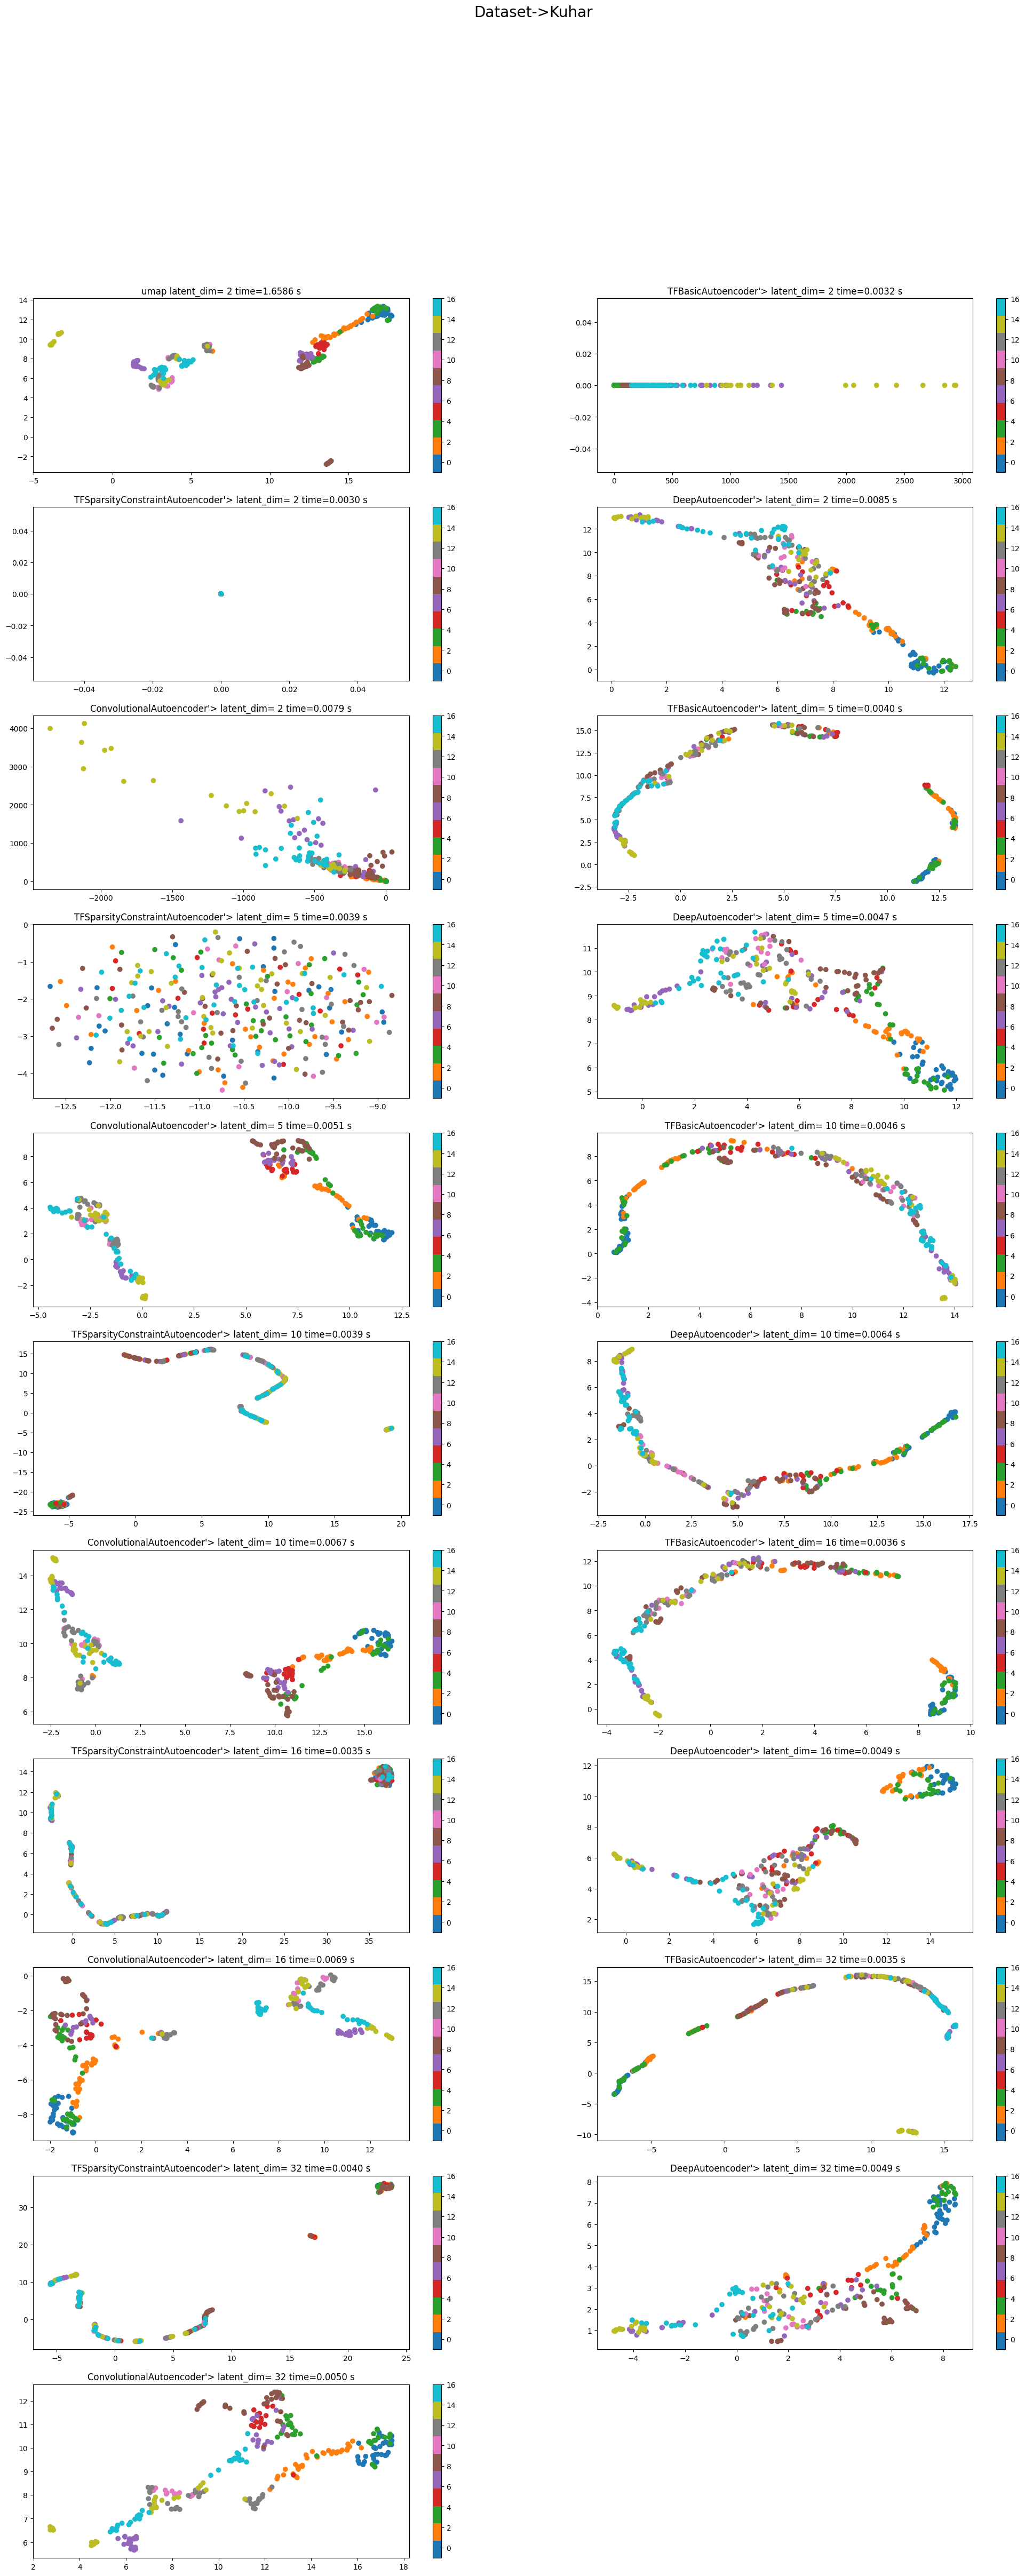

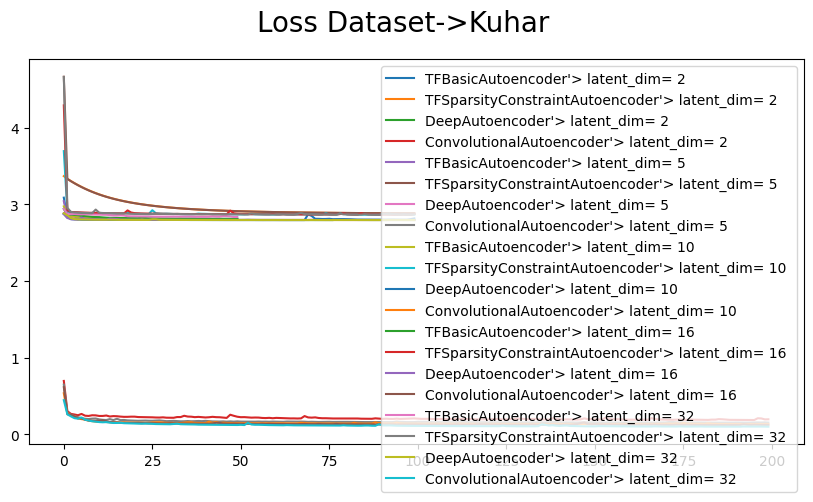

In [16]:
### dataset HAR

reducers = [
    (TFBasicAutoencoder, { "latent_dim": 2,'epochs': 50}),
   (TFSparsityConstraintAutoencoder, { "latent_dim": 2,'epochs': 100}),
    (DeepAutoencoder, { "latent_dim": 2,'epochs': 100}),
    (ConvolutionalAutoencoder, { "latent_dim": 2,'epochs': 200}),    
     (TFBasicAutoencoder, { "latent_dim": 5,'epochs': 50}),
   (TFSparsityConstraintAutoencoder, { "latent_dim": 5,'epochs': 100}),
    (DeepAutoencoder, { "latent_dim": 5,'epochs': 100}),
    (ConvolutionalAutoencoder, { "latent_dim": 5,'epochs': 200}), 
     (TFBasicAutoencoder, { "latent_dim": 10,'epochs': 50}),
   (TFSparsityConstraintAutoencoder, { "latent_dim": 10,'epochs': 100}),
    (DeepAutoencoder, { "latent_dim": 10,'epochs': 100}),
    (ConvolutionalAutoencoder, { "latent_dim": 10,'epochs': 200}), 
     (TFBasicAutoencoder, { "latent_dim": 16,'epochs': 50}),
   (TFSparsityConstraintAutoencoder, { "latent_dim": 16,'epochs': 100}),
    (DeepAutoencoder, { "latent_dim": 16,'epochs': 100}),
    (ConvolutionalAutoencoder, { "latent_dim": 16,'epochs': 200}),
     (TFBasicAutoencoder, { "latent_dim": 32,'epochs': 50}),
   (TFSparsityConstraintAutoencoder, { "latent_dim": 32,'epochs': 100}),
    (DeepAutoencoder, { "latent_dim": 32,'epochs': 100}),
    (ConvolutionalAutoencoder, { "latent_dim": 32,'epochs': 200}), 
]

datasets= ['Kuhar']

,#'custom','har'kuhar
train_datasets(reducers,datasets)

In [ ]:
for a in data_encoded:
    print(a.shape)


Custom (16640, 6) (16640, 1) (4160, 6) (4160, 1) 6
6
Epoch 1/50
520/520 [==============================] - 1s 1ms/step - loss: 0.8353 - val_loss: 0.7174
Epoch 2/50
520/520 [==============================] - 1s 1ms/step - loss: 0.6867 - val_loss: 0.6590
Epoch 3/50
520/520 [==============================] - 1s 1ms/step - loss: 0.6438 - val_loss: 0.6270
Epoch 4/50
520/520 [==============================] - 1s 1ms/step - loss: 0.6155 - val_loss: 0.5924
Epoch 5/50
520/520 [==============================] - 1s 1ms/step - loss: 0.5699 - val_loss: 0.5600
Epoch 6/50
520/520 [==============================] - 1s 1ms/step - loss: 0.5605 - val_loss: 0.5581
Epoch 7/50
520/520 [==============================] - 1s 1ms/step - loss: 0.5587 - val_loss: 0.5562
Epoch 8/50
520/520 [==============================] - 1s 1ms/step - loss: 0.5565 - val_loss: 0.5535
Epoch 9/50
520/520 [==============================] - 1s 1ms/step - loss: 0.5536 - val_loss: 0.5504
Epoch 10/50
520/520 [==========================

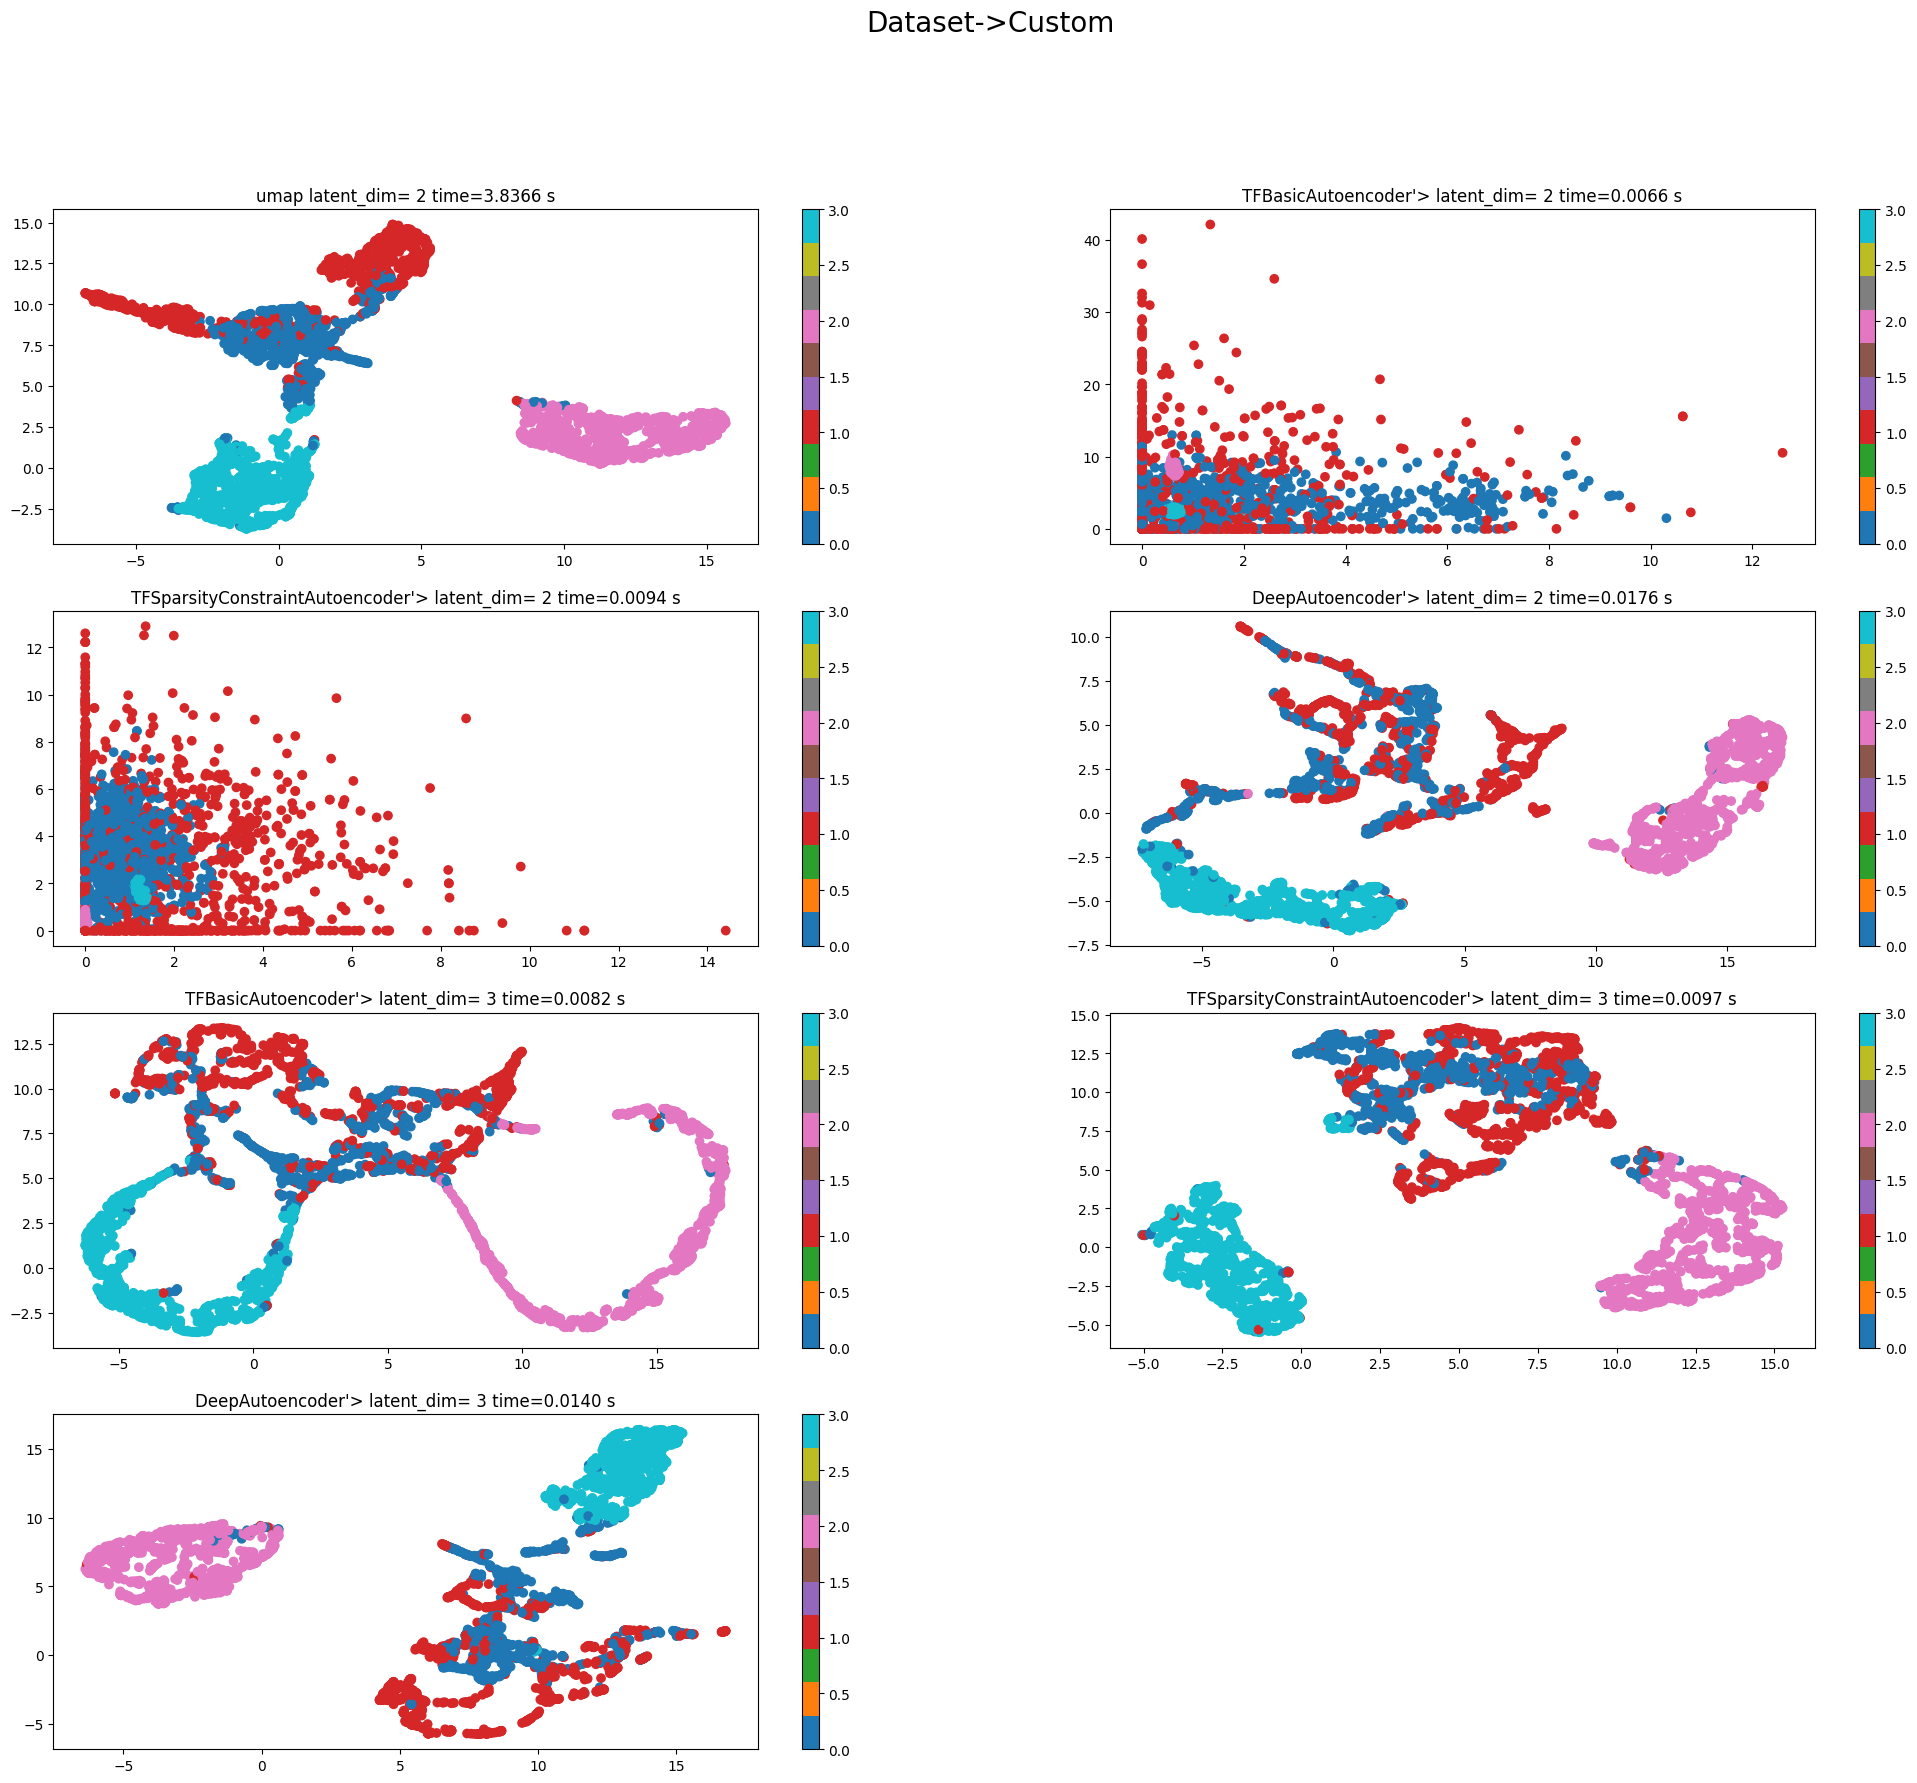

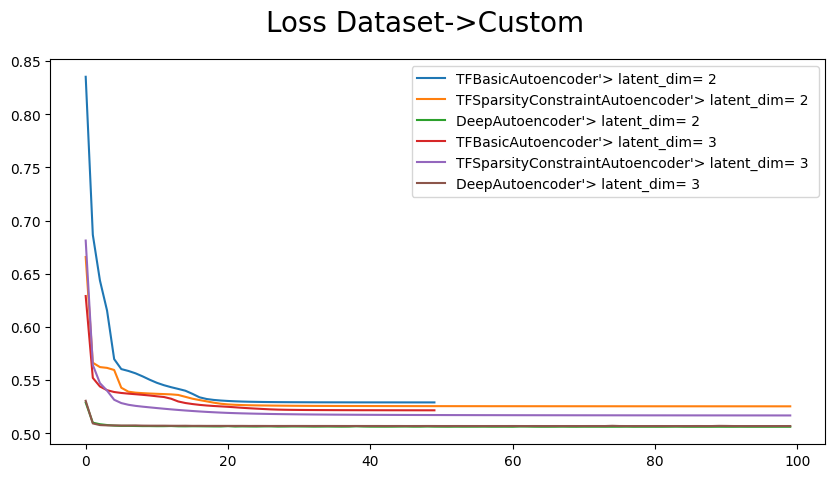

In [61]:
### dataset HAR

reducers = [
    (TFBasicAutoencoder, { "latent_dim": 2,'epochs': 50}),
   (TFSparsityConstraintAutoencoder, { "latent_dim": 2,'epochs': 100}),
    (DeepAutoencoder, { "latent_dim": 2,'epochs': 100}),
    (TFBasicAutoencoder, { "latent_dim": 3,'epochs': 50}),
   (TFSparsityConstraintAutoencoder, { "latent_dim": 3,'epochs': 100}),
    (DeepAutoencoder, { "latent_dim": 3,'epochs': 100}),   

]

datasets= ['Custom']

,#'custom','har'kuhar
train_datasets(reducers,datasets)